In [1]:
import numpy as np, xarray as xr, matplotlib.pyplot as plt, pandas as pd, s3fs, xesmf, time
from utils import *
import dask.array as da
from dask.diagnostics import ProgressBar
from dask.distributed import Client, LocalCluster

%load_ext autoreload
%autoreload 2

s3 = s3fs.S3FileSystem(key="K1CQ7M1DMTLUFK182APD", secret="3JuZAQm5I03jtpijCpHOdkAsJDNLNfZxBpM15Pi0", 
                       client_kwargs=dict(endpoint_url="https://rgw.met.no"))

In [6]:
client.close()

In [2]:
cluster = LocalCluster(n_workers=16, memory_limit='20GB') #16 is best (matches number of cores)
client = Client(cluster)

In [44]:
#tosBS = clip_to_region(get_bucket_data('tos', thing='Omon', model='NorESM2-LM', experiment='historical'))
#SI = clip_to_region(get_bucket_data('siconc', thing='SImon', model='NorESM2-LM', experiment='historical'))

# Temperature

In [ ]:
tos_anomaly = time_anomaly(tosBS, 0, 12*30, -12*30, -1)
tos_anomaly.plot()

In [ ]:
tosBSmean = regional_average(tosBS.tos.isel(time=slice(-12*70, -1)), model='NorESM2-LM')
tosBSmean.isel(time=slice(-12*50, -1)).plot(x='time')

# Sea Ice

In [ ]:
SImean = regional_average(SI, model='NorESM-LM')

SIMarch = SI.groupby('time.month')[3]
SIMarchSpatialMean = regional_average(SIMarch, areacello.areacello)

SISeptember = SI.groupby('time.month')[9]
SISeptemberSpatialMean = regional_average(SISeptember, areacello.areacello)

In [ ]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(12,8))

SIMarchSpatialMean.isel(time=slice(-12*65, -1)).plot(ax=ax[0,0])
SISeptemberSpatialMean.isel(time=slice(-12*65, -1)).plot(ax=ax[0,1])

time_anomaly(SIMarch, 0, 12*30, -12*30, -1).plot(ax=ax[1,0])
time_anomaly(SISeptember, 0, 12*30, -12*30, -1).plot(ax=ax[1,1])

plt.show()

In [ ]:
SImeanMarch = SImean.groupby('time.month')[3]
SImeanSeptember = SImean.groupby('time.month')[9]
SImeanMarch.plot()
SImeanSeptember.plot()

# Chlorofyll

In [185]:
# NOT NEEDED ANYMORE! ALL DAILY CHLOS READ TO FILE FOR BARENTS (april-september) Takes 15 mins to read all in if not
# start = time.time()
# chlos = clip_to_months(clip_to_region(get_bucket_data('chlos', time_res='daily', thing='Oday', 
#                                        experiment='historical')), 4, 8)
# print(time.time() - start)
#chlos.chlos.to_netcdf('chlos_NorESM2-LM_historical_all')

In [3]:
chlos_daily = xr.load_dataset('chlos_NorESM2-LM_historical_all')

In [ ]:
chlos_daily_mean = regional_average(chlos_daily)

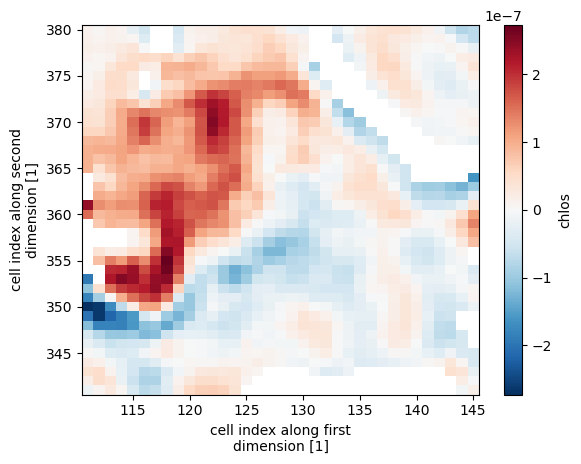

In [186]:
chlos_daily_anomaly = time_anomaly(chlos_daily, 0, 365*30, -365*30, -1)
chlos_daily_anomaly.chlos.plot()

<AxesSubplot:xlabel='year', ylabel='dayofyear'>

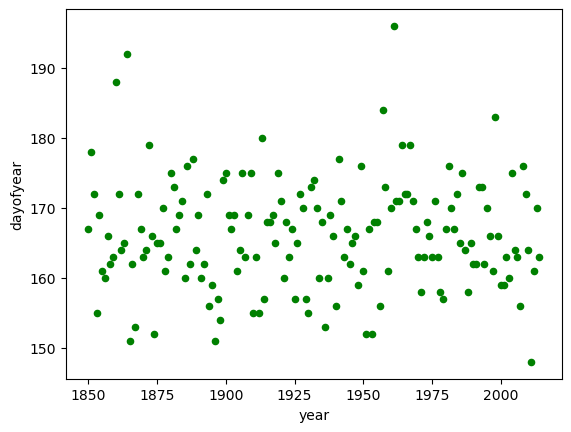

In [184]:
peak_dates = find_peak_dates(chlos_daily_mean.chlos)
peak_dates.plot.scatter(x='year', y='dayofyear', color='g')

AttributeError: 'Line2D' object has no property 'title'

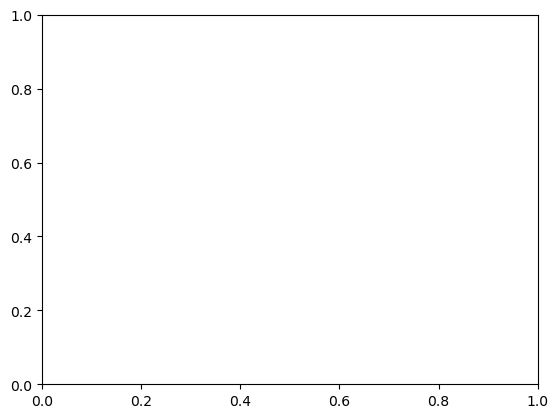

In [187]:
tmp_mean = chlos_daily_mean.chlos.groupby('time.dayofyear').mean().plot(title='Mean sesonal cycle across all years')

AttributeError: 'list' object has no attribute 'isel'

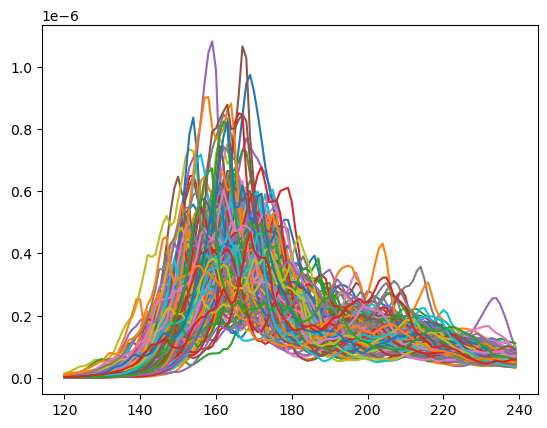

In [82]:
fig, ax = plt.subplots()
#average_yearly_cycle = chlos_daily_mean.chlos.groupby('time.dayofyear').mean()

[ax.plot(np.arange(120, 120+30*4), tmp[year].isel(time=slice(120, 120+30*4)), label=year) for year in range(1850, 2014)]

ax.plot(np.arange(120, 120+30*4), tmp_mean.isel(time=slice(120, 120+30*4)), linewidth=3, color='k')
#ax.legend()
plt.show()

Do we see a shift in the peak phytoplankton blooming date in the Barentz sea in connection to the sea ice retreat?

In [11]:
start = time.time()
with ProgressBar():
    chlos_daily_mean.compute()
print(time.time() - start)

0.027305126190185547


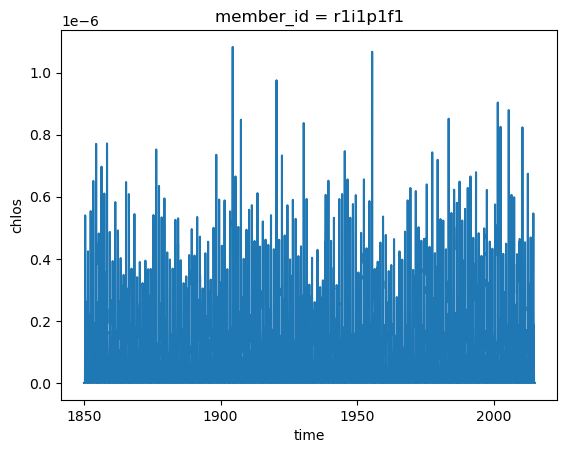

In [18]:
chlos_daily_mean.chlos.plot()

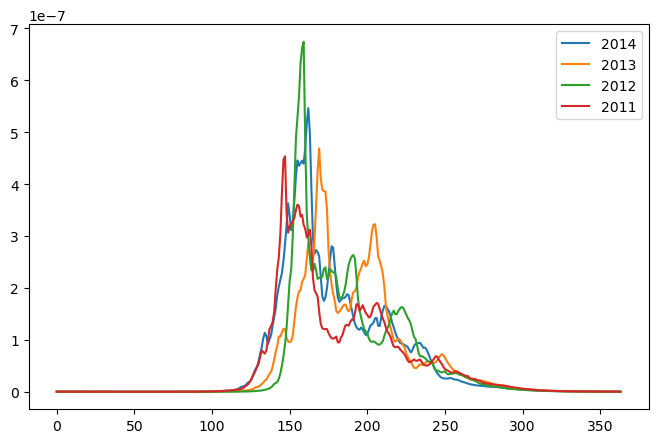

30.77193307876587


In [15]:
start = time.time()
fig, ax = plt.subplots(figsize=(8, 5))

[ax.plot(np.arange(364), chlos_mean.isel(time=slice(-(i+1)*365, -i*365-1)), label=2014-i) for i in range(4)]

#chlos_mean.chlos.isel(time=slice(-365, -1)).plot(ax=ax, color='r', label='2014')
#chlos_mean.chlos.isel(time=slice(-2*365, -365)).plot(ax=ax, color='g', label='2013')
#chlos_mean.chlos.isel(time=slice(-3*365, -2*365)).plot(ax=ax, color='b', label='2012')
#chlos_mean.chlos.isel(time=slice(-4*365, -3*365)).plot(ax=ax, color='y', label='2011')
ax.legend()
plt.show()
print(time.time() - start)

månedlig noresm chlos for å se peak, plotte oppå /OBS-ESACCI-OC/

For NorESM2 chlorophyll, time by 10 to get total mass when integrating for surface layer

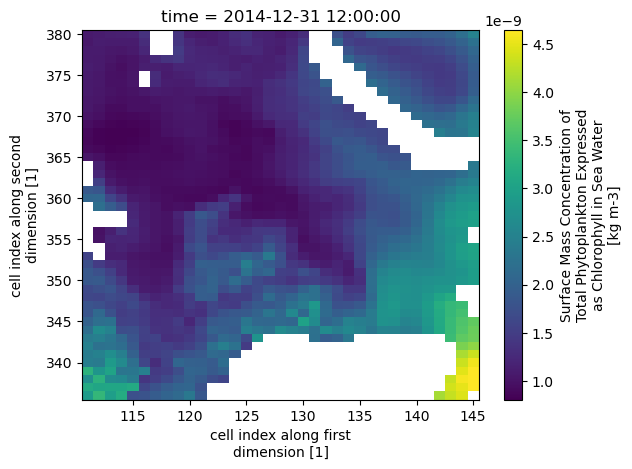

In [3]:
chlos_monthly = get_bucket_data('chlos'